## Polymer Project: 
## Implementation of the pivot algorithm to simulate Self-avoiding-random walks

 Names: Mandus Aldag, Alexandros Mylanos

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time
from tqdm import tqdm


In [2]:
def check_self_avoidance(coords, pivot = None):
    # False = Self avoidant
    # True = not Self avoidant

    if pivot == None:
        N = np.size(coords, axis=1)
        hashset = set()
        for i in range(N):
            tmp_tuple = tuple(coords[:,i])
            if tmp_tuple in hashset:
                return True
            else:
                hashset.add(tmp_tuple)
                
        
        return False
    
    else:
        N = np.size(coords, axis=1)
        if pivot >= N//2:
            longer_site= pivot 
            shorter_site= N-pivot-1
            dir = -1
        else:
            longer_site = N-pivot-1
            shorter_site = pivot
            dir = 1
       
        hashset=set()
        for i in range(1,longer_site+1):
            if i > shorter_site:   # Case when we scan only in the longer direction from thepivot because the short direction was already fully scanned
                tmp_tuple = tuple(coords[:,pivot+i*dir])
                if tmp_tuple in hashset:
                    return True
                else:
                    hashset.add(tmp_tuple)
            else: # Check in both directions of the pivot
                tmp_tuple = tuple(coords[:,pivot+i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
                tmp_tuple = tuple(coords[:,pivot-i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
        return False
                    

In [3]:
def generate_random_walk(L):
    coord = np.zeros((2,L),dtype=int)
    for l in range(1,L):
        direction = np.random.randint(0,4) # clock wise starting from the top
        if direction == 0:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]+1 

        elif  direction == 1:
            coord[0,l] = coord[0,l-1]+1
            coord[1,l] = coord[1,l-1]
        
        elif  direction == 2:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]-1

        elif  direction == 3:
            coord[0,l] = coord[0,l-1]-1
            coord[1,l] =  coord[1,l-1]
    
    return coord
        

In [4]:
def initial_SAW(N: int): #Dimerisation
    if N <= 5:
        tmp = True
        while tmp:
            walk = generate_random_walk(N)
            tmp = check_self_avoidance(walk)
        return walk



    else:
        tmp = True
        while tmp:
            first = initial_SAW(N//2)
            second = initial_SAW(N-N//2+1)
            translated = (first[:,-1]+second.T).T
            concatenated = np.concatenate((first,translated[:,1:]),axis=1)
            tmp = check_self_avoidance(concatenated)

        return concatenated


In [131]:
def pivot_point(coord):
    N = np.size(coord,axis=1)
    return np.random.randint(1,N)

def symmetry_op(coord):
    N = np.size(coord,axis=1)
    g = np.random.randint(0,7)
    if g==0: #+90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[1,0]]), coord[:,i])
    elif g==1: #-90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[-1,0]]), coord[:,i])
    elif g==2: #180°
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,-1]]), coord[:,i])
    elif g==3: #x-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[1,0],[0,-1]]), coord[:,i])
    elif g==4: #y-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,1]]), coord[:,i])
    elif g==5: #diagonal reflection upperright-bottomleft
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[1,0]]), coord[:,i])
    elif g==6: #diagonal reflection upperleft-bottomright
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[-1,0]]), coord[:,i])
    #print("g = ",g)
    return coord
    

In [182]:
def pivot_step(coord):
    global accepted
    N = np.size(coord,axis=1)
    pivot = np.random.randint(1,N-1)
    #print("pivot = ",pivot)
    to_be_operated = coord[:,pivot:]
    to_be_operated = (to_be_operated.T-to_be_operated[:,0]).T
    operated = symmetry_op(to_be_operated)
    operated = (operated.T+coord[:,pivot]).T

    coord_new = np.concatenate((coord[:,:pivot],operated),axis=1)
    not_selfavoidant = check_self_avoidance(coord_new,pivot)
    if not_selfavoidant:
        #print("Not selfavoidant")
        return coord
    else:
        accepted +=1
        return coord_new


In [7]:
def squared_end_to_end(coord):
    return np.linalg.norm(coord[:,-1])**2

def squared_gyration(coord):
    N = np.size(coord,axis=1)
    a = (1/N * np.sum(coord,axis=1))
    inbracket = np.dot(a,a)
    result = 0
    for i in range(N):
        result += np.dot(coord[:,i], coord[:,i])-inbracket
    return 1/N * result

In [ ]:
def pivot_run(coord,iterations):
    global accepted
    accepted = 0
    ω_squared = []
    S_squared = []
    for i in tqdm(range(iterations)):
        coord = pivot_step(coord)
        ω_squared.append(squared_end_to_end(coord))
        S_squared.append(squared_gyration(coord))
    return ω_squared, S_squared, accepted/iterations

In [15]:
def autocorrelation(timeseries, mean=None):
    timeseries = np.array(timeseries)
    if mean is None:
        mean = timeseries.mean()
    fluctuations = timeseries-mean

    C = np.fft.ifft(np.fft.fft(fluctuations) * np.fft.ifft(fluctuations)).real
    return C/C[0]

def integrated_autocorrelation_time(timeseries, mean=None, until=None):
    steps = len(timeseries)
    if until is None:
        until = steps // 2
    Gamma = autocorrelation(timeseries, mean=mean)[:until]
    try:
        first_zero = np.where(Gamma <= 0)[0][0]
        return 0.5 + Gamma[1:first_zero].sum()
    except:
        # Gamma never hits 0.  So the autocorrelation spans ~ the whole ensemble.
        return steps # at least!

17.0


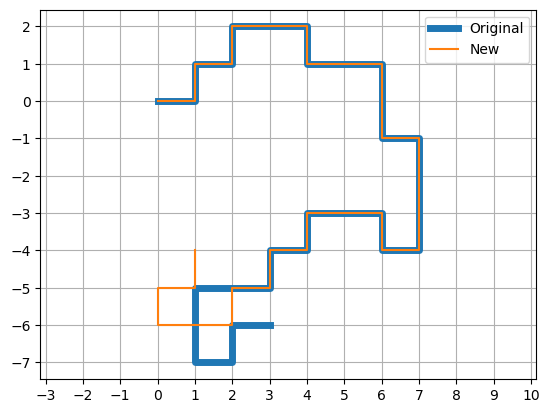

In [195]:
test = initial_SAW(30)
plt.plot(test[0,:],test[1,:],linewidth=5,label="Original")
new = pivot_step(test)
print(squared_end_to_end(new))
plt.plot(new[0,:],new[1,:],label="New")
ax = plt.gca() 
ax.xaxis.set_major_locator(MultipleLocator(1))  # X ticks every 1 unit
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()

# Preliminary Tests

In [183]:
iterations = 10**6
N=15
coord = initial_SAW(N)
accepted = 0
ω_squared, S_squared,f = pivot_run(coord,iterations)
mean_ω_squared = np.mean((ω_squared))
mean_S_squared = np.mean((S_squared))
std_ω_squared = np.std((ω_squared))
std_S_squared = np.std((S_squared))
ur = mean_S_squared/mean_ω_squared
print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {std_ω_squared}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {std_S_squared}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)

100%|██████████| 1000000/1000000 [00:39<00:00, 25313.62it/s]


Mean squared end-to-end distance is: 42.834144 ± 26.274475594905105
Mean squared gyration radius is: 6.168419226666667 ± 2.0520282124742435
Universal ratio is: 0.1440070619052564
Acceptance rate f =  0.556048


4


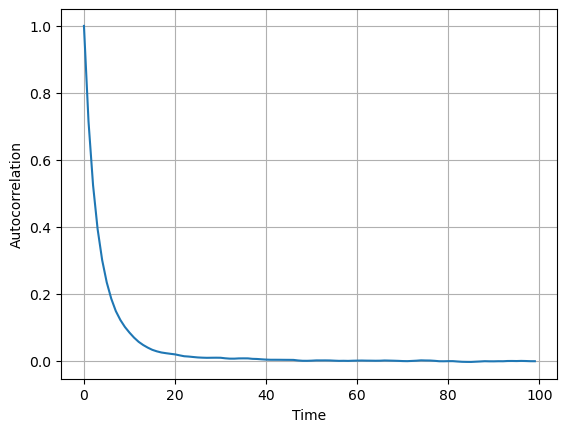

In [139]:
autocor = autocorrelation(ω_squared)
plt.plot(autocor[0:100])
plt.grid()
plt.xlabel("Time")
plt.ylabel("Autocorrelation")
τ_int = integrated_autocorrelation_time(ω_squared)
print((int(np.ceil(τ_int))))

In [184]:
iterations = 10**6
N=20
coord = initial_SAW(N)
ω_squared20, S_squared20,f20 = pivot_run(coord,iterations)
mean_ω_squared20 = np.mean((ω_squared20))
mean_S_squared20 = np.mean((S_squared20))
std_ω_squared20 = np.std((ω_squared20))
std_S_squared20 = np.std((S_squared20))
ur20 = mean_S_squared20/mean_ω_squared20
print(f"Mean squared end-to-end distance is: {mean_ω_squared20} ± {std_ω_squared20}")
print(f"Mean squared gyration radius is: {mean_S_squared20} ± {std_S_squared20}")
print(f"Universal ratio is: {ur20}")
print(f"Acceptance rate f = ",f20)


100%|██████████| 1000000/1000000 [00:47<00:00, 20853.00it/s]


Mean squared end-to-end distance is: 66.819972 ± 41.93055217760929
Mean squared gyration radius is: 9.51013457 ± 3.2645001676276424
Universal ratio is: 0.14232473144406585
Acceptance rate f =  0.529302


In [186]:
iterations = 10**6
N=1000
start = time.time()
coord = initial_SAW(N)
end = time.time()
print("Dimerization time:", end - start)
ω_squared1000, S_squared1000,f1000 = pivot_run(coord,iterations)


Dimerization time: 189.40895771980286


100%|██████████| 1000000/1000000 [26:57<00:00, 618.21it/s]


In [187]:
mean_ω_squared1000 = np.mean((ω_squared1000 ))
mean_S_squared1000 = np.mean((S_squared1000 ))
std_ω_squared1000  = np.std((ω_squared1000 ))
std_S_squared1000  = np.std((S_squared1000 ))
ur1000 = mean_S_squared1000 /mean_ω_squared1000 
print(f"Mean squared end-to-end distance is: {mean_ω_squared1000 } ± {std_ω_squared1000 }")
print(f"Mean squared gyration radius is: {mean_S_squared1000}  ± {std_S_squared1000 }")
print(f"Universal ratio is: {ur1000 }")
print(f"Acceptance rate f = ",f1000 )


Mean squared end-to-end distance is: 24386.923612 ± 16335.893503971825
Mean squared gyration radius is: 3413.285966735517  ± 1304.429491696378
Universal ratio is: 0.1399637781723297
Acceptance rate f =  0.252782


In [6]:
import numpy as np
import time

# Create large random arrays
n, m = 20000, 20000
first = np.random.rand(n)
second = np.random.rand(n, m)

# Method 1: Broadcasting
start = time.time()
result1 = second + first[:, np.newaxis]
end = time.time()
print("Broadcasting time:", end - start)

# Method 2: Transposing
start = time.time()
result2 = (first + second.T).T  # Assuming first is (n, m), otherwise just first
end = time.time()
print("Transposing time:", end - start)

# Verify both methods produce the same result
print("Results match:", np.allclose(result1, result2))


Broadcasting time: 0.23731660842895508
Transposing time: 0.2448711395263672
Results match: True
